In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras import optimizers

from keras_preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121 as BASE

from sklearn.metrics import roc_curve, auc, roc_auc_score

Using TensorFlow backend.


In [2]:
# -----------------------------LOAD IN OUR DATA---------------------------------- #
VALID = 'CheXpert-v1.0-small/valid.csv'
WEIGHTS = 'DenseNet121_16_6_weights_lr_reduce_from32.hdf5'

# generate validation set
valid = pd.read_csv(VALID, dtype=str)

#mapping to different labels
label = {'0.0': '0', '1.0' : '1', '-1.0' : '1'}

#same for validation set even though there should be no issue here with missing data
valid['label'] = valid['Pleural Effusion'].map(label)
num_valid = len(valid)

print(valid['label'].value_counts())


0    167
1     67
Name: label, dtype: int64


In [3]:
valid.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,label
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
#---------------------------------CREATE TEST DATA GENERATOR---------------------------------#
def test_flow(valid, target_size, batch_size = 1, color_mode="grayscale",  x = 'Path', y= 'label'):

    #declare the datagen options
    valid_datagen = ImageDataGenerator(rescale=1./255)

    valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid,
                                                        directory=None,
                                                        x_col=x,
                                                        y_col=y,
                                                        class_mode="binary",
                                                        color_mode=color_mode,
                                                        seed = 42,
                                                        shuffle = False,
                                                        target_size=target_size,
                                                        batch_size=batch_size)

    return valid_generator


valid_generator = test_flow(valid, (224,224), color_mode="rgb")

Found 234 validated image filenames belonging to 2 classes.


In [51]:
# # -----------------------------LOAD MODEL---------------------------------- #
conv_base = BASE(include_top=True,
                input_shape=valid_generator.image_shape,
                pooling=max)

conv_base.layers.pop()
print(conv_base.summary())

# conv_base.trainable = True
# for layer in conv_base.layers:
#     layer.trainable = True

model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(1, activation='sigmoid'))

if WEIGHTS:
    model.load_weights(WEIGHTS)

model.compile(loss='binary_crossentropy', optimizer= optimizers.Adam(), metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [6]:
scoreSeg = model.evaluate_generator(valid_generator, steps=len(valid), workers=0)
print('--------------------------')
print('')
print("Accuracy (Evaluation Generator)= ",scoreSeg[1])
print('')

--------------------------

Accuracy (Evaluation Generator)=  0.8803418803418803



In [7]:
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_VALID

234

In [8]:
valid_generator.reset()
y_pred_keras = model.predict_generator(valid_generator, steps=STEP_SIZE_VALID, verbose=1, workers=0)

234/234 [==============================] - 63s 269ms/step


In [9]:
valid['y_prob'] = y_pred_keras

valid['y_pred'] = round(valid['y_prob'])

pd.crosstab(valid['label'], valid['y_pred'])

y_pred,0.0,1.0
label,,
0,161,6
1,22,45


One issue we see immediately is the ammount of false negatives in our group. I would think that is our most concerning group as it shows that we miss almost 32% of our positive cases! This makes some sense as we have an imbalanced training data set.

In [10]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_generator.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
print('--------------------------')
print('')
print('Model AUC: %s' % str(round(auc_keras, 4)))
print('')
print('--------------------------')

--------------------------

Model AUC: 0.9198

--------------------------


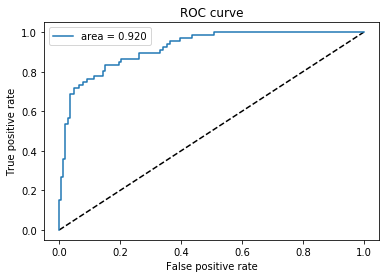

In [11]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Our model AUC is not significantly worse that the baseline, although it does not perform better, and considering our errors are primarily related to false negatives it is difficult to gauge the reliability of this model.

In [12]:
valid['patient_id'] = [item[2] for item in valid['Path'].str.split("/")]
valid['study_id'] = [item[3] for item in valid['Path'].str.split("/")]
valid.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,label,y_prob,y_pred,patient_id,study_id
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.035437,0.0,patient64541,study1
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0.022680,0.0,patient64542,study1
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0.012251,0.0,patient64542,study1
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.245853,0.0,patient64543,study1
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.012708,0.0,patient64544,study1


In [13]:
groupLabel = ['patient_id','study_id','Sex','Age','label']
test = valid[['patient_id','study_id','Sex','Age','label','y_prob']].groupby(groupLabel).max().reset_index()

In [14]:
test.head()

,patient_id,study_id,Sex,Age,label,y_prob
0,patient64541,study1,Male,73,0,0.035437
1,patient64542,study1,Male,70,0,0.022680
2,patient64543,study1,Male,85,0,0.245853
3,patient64544,study1,Female,42,0,0.012708
4,patient64545,study1,Female,55,1,0.553526


In [87]:
test['y_pred'] = round(test['y_prob'])

pd.crosstab(test['label'], test['y_pred'])

y_pred,0.0,1.0
label,,
0,130,6
1,20,44


In [16]:
labels = list(map(int, list(test['label'])))

In [17]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, test['y_prob'])
auc_keras = auc(fpr_keras, tpr_keras)
print('--------------------------')
print('')
print('Model AUC: %s' % str(round(auc_keras, 4)))
print('')
print('--------------------------')

--------------------------

Model AUC: 0.9148

--------------------------


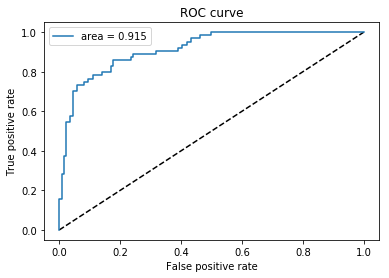

In [18]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Bootstrapped AUC for confidence intervals.

In [80]:
from sklearn.utils import resample
n_bootstraps = 10000
seed = 42
bootstrapped_scores = []

for i in range(n_bootstraps):
    # prepare bootstrap sample
    boot = resample(test, replace=True, n_samples=50)
    if len(np.unique(boot['label'])) == 2:
        score = roc_auc_score(boot['label'], boot['y_prob'])
        bootstrapped_scores.append(score)

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.819 - 0.984]


Get some other simple statistics for comparisons

In [88]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(labels, test['y_prob'])

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.85


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.85')

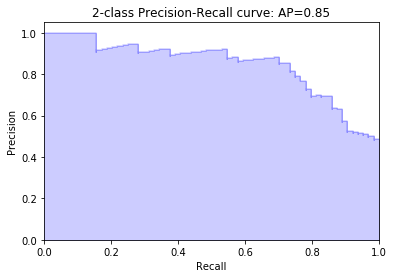

In [89]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(labels, test['y_prob'])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

Overall we see that we are not significantly different from current state of the art models for the task of predicting pleural effusions.

Lets plot some of the X-rays with overlayed heatmaps to determine what areas are driving the predictions.

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1000)              7037504   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1001      
Total params: 7,038,505
Trainable params: 6,954,857
Non-trainable params: 83,648
_________________________________________________________________


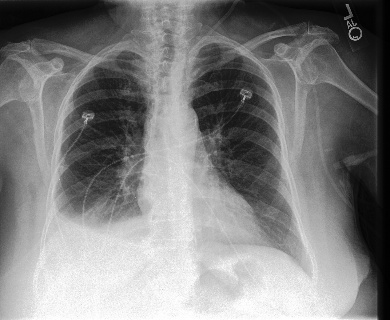

In [24]:
from IPython.display import Image
img_path = 'CheXpert-v1.0-small/valid/patient64577/study1/view1_frontal.jpg'
Image(filename=img_path) 

In [25]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img = image.load_img(img_path, target_size=(224, 224))

#convert to array
x = image.img_to_array(img)

#create batch size of 1
x = np.expand_dims(x, axis=0)

#normalize RGB range
x = preprocess_input(x)

#show input size
print(x.shape)

(1, 224, 224, 3)


In [27]:
preds = model.predict(x)
preds

array([[0.97689974]], dtype=float32)

In [56]:
model.get_layer('densenet121').summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [58]:
from keras import backend as K
import matplotlib.pyplot as plt

output = model.output[:, 0]
print(output)

last_conv_layer = model.get_layer('densenet121').get_layer('relu')
print(last_conv_layer.output)

grads = K.gradients(output, last_conv_layer.output)
print(grads)

Tensor("strided_slice_18:0", shape=(?,), dtype=float32)
Tensor("relu_1/Relu:0", shape=(?, 7, 7, 1024), dtype=float32)
[None]
